# Kernel Density Estimation for Foreground Detection

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

ROOT = Path.cwd().parent          # .../assignment-5-atharvv04
Q1_DIR = ROOT / "Data" / "Q1"

BG_PATH = Q1_DIR / "back.jpg"     # background only
TEST_PATH = Q1_DIR / "Full.jpg"   # person + background

print("Background image path:", BG_PATH)
print("Test image path:", TEST_PATH)

USERNAME = "atharv.bhatt"

def add_username(fig):
    fig.text(0.99, 0.01, USERNAME, ha="right", va="bottom", fontsize=8)

Background image path: c:\Users\athar\Documents\VS_Code\SEM_5\SMAI\assignment-5-atharvv04\Data\Q1\back.jpg
Test image path: c:\Users\athar\Documents\VS_Code\SEM_5\SMAI\assignment-5-atharvv04\Data\Q1\Full.jpg


Background shape: (400, 400, 3)
Test shape      : (400, 400, 3)
Background features: (160000, 3)
Test features      : (160000, 3)


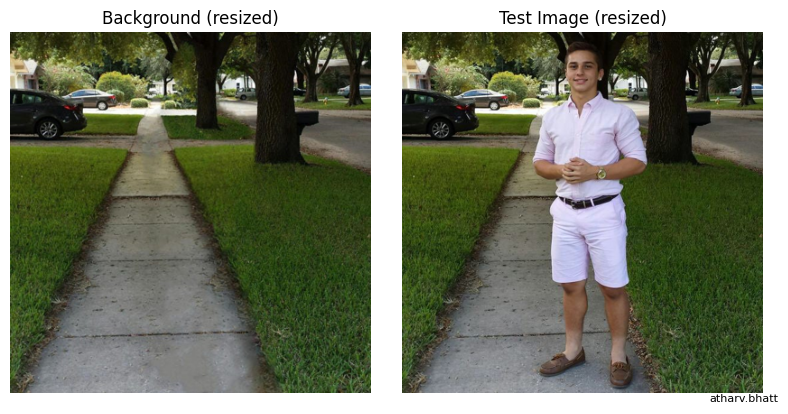

In [7]:
TARGET_SIZE = (400, 400)   # (width, height)

def load_and_preprocess_image(path, target_size=TARGET_SIZE):
    """
    Load an image, resize to target_size and return:
    - img_pil : PIL image
    - img_arr : float32 numpy array in [0,1] of shape (H, W, 3)
    """
    img = Image.open(path).convert("RGB")
    img = img.resize(target_size)  # same size for bg and test
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return img, arr

bg_pil, bg_arr = load_and_preprocess_image(BG_PATH)
test_pil, test_arr = load_and_preprocess_image(TEST_PATH)

print("Background shape:", bg_arr.shape)
print("Test shape      :", test_arr.shape)

# Flatten into feature vectors: each pixel -> [R,G,B]
bg_feats = bg_arr.reshape(-1, 3)     # (N_bg, 3)
test_feats = test_arr.reshape(-1, 3) # (N_test, 3)

print("Background features:", bg_feats.shape)
print("Test features      :", test_feats.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(bg_arr)
axes[0].set_title("Background (resized)")
axes[0].axis("off")

axes[1].imshow(test_arr)
axes[1].set_title("Test Image (resized)")
axes[1].axis("off")

plt.tight_layout()
add_username(fig)
plt.show()

## 1.2 - Custom KDE class

- We use:
    - Kernels: `"gaussian"`, `"triangular"`, `"uniform"`.
    - Smart sampling with `max_samples` to limit background points.
    - Batched prediction to avoid huge `(num_pixels × num_pixels)` arrays.

In [9]:
import math

class KDE:
    """
    Simple Kernel Density Estimator implemented with NumPy only.

    Parameters
    ----------
    kernel : {'gaussian', 'triangular', 'uniform'}
        Kernel type.
    bandwidth : float
        Smoothing parameter h > 0.
    max_samples : int or None
        If not None, randomly subsample at most this many background points.
    random_state : int
        RNG seed for reproducible sampling.
    """
    def __init__(self, kernel="gaussian", bandwidth=0.1,
                 max_samples=3000, random_state=42):
        if bandwidth <= 0:
            raise ValueError("bandwidth must be positive")
        if kernel not in {"gaussian", "triangular", "uniform"}:
            raise ValueError(f"Unsupported kernel: {kernel}")
        self.kernel = kernel
        self.bandwidth = float(bandwidth)
        self.max_samples = max_samples
        self.random_state = random_state

        self.X = None   # training data (n, d)
        self.n = None
        self.d = None

    def fit(self, data: np.ndarray):
        """
        Store (and possibly subsample) training data.

        data : array-like, shape (n_samples, n_features)
        """
        data = np.asarray(data, dtype=np.float64)
        if data.ndim != 2:
            raise ValueError("data must be 2D (n_samples, n_features)")

        n, d = data.shape
        self.d = d

        # Smart sampling: random subset if too many pixels
        if self.max_samples is not None and n > self.max_samples:
            rng = np.random.default_rng(self.random_state)
            idx = rng.choice(n, size=self.max_samples, replace=False)
            data = data[idx]
            n = data.shape[0]

        self.X = data
        self.n = n
        return self

    def _kernel(self, u: np.ndarray) -> np.ndarray:
        """
        Evaluate kernel K(u) for u with shape (..., d).
        Returns array with shape (...) (last dimension reduced).
        """
        if self.kernel == "gaussian":
            # (2π)^(-d/2) * exp(-0.5 * ||u||^2)
            quad = np.sum(u ** 2, axis=-1)
            norm_const = (2 * math.pi) ** (-self.d / 2)
            return norm_const * np.exp(-0.5 * quad)

        elif self.kernel == "triangular":
            # ∏ max(0, 1 - |u_j|)
            return np.prod(np.clip(1.0 - np.abs(u), 0.0, None), axis=-1)

        else:  # 'uniform'
            # ∏ 1(|u_j| <= 0.5)
            inside = (np.abs(u) <= 0.5).astype(np.float64)
            return np.prod(inside, axis=-1)

    def predict(self, samples: np.ndarray, batch_size: int = 4096) -> np.ndarray:
        """
        Estimate densities fˆ(x) for given samples.

        samples : array-like, shape (m, d)
        batch_size : process samples in chunks for lower memory.

        Returns
        -------
        densities : np.ndarray, shape (m,)
            Estimated density at each sample.
        """
        if self.X is None:
            raise RuntimeError("Call fit() before predict().")

        samples = np.asarray(samples, dtype=np.float64)
        if samples.ndim != 2 or samples.shape[1] != self.d:
            raise ValueError(f"samples must be (m, {self.d})")

        m = samples.shape[0]
        densities = np.empty(m, dtype=np.float64)

        for start in range(0, m, batch_size):
            end = min(start + batch_size, m)
            chunk = samples[start:end]        # (b, d)

            # u = (x - x_i) / h => shape (b, n, d)
            u = (chunk[:, None, :] - self.X[None, :, :]) / self.bandwidth

            # K(u) -> (b, n)
            k_vals = self._kernel(u)

            # fˆ(x) = 1 / (n h^d) Σ_i K(u_i)
            dens = k_vals.mean(axis=1) / (self.bandwidth ** self.d)
            densities[start:end] = dens

        return densities

## 1.3 - Foreground Detection

1. Fit KDE on background features.
2. Predict density at every pixel in the test image.
3. Choose a threshold based on a low percentile of those densities (e.g. 5%). Pixels with very low probability under the background model are marked as foreground.

In [10]:
def segment_foreground(
    bg_feats,
    test_feats,
    kernel="gaussian",
    bandwidth=0.1,
    max_samples=3000,
    batch_size=4096,
    foreground_percent=5.0,
):
    """
    Fit KDE on bg_feats and segment foreground on test_feats.
    Returns:
        density_map : (H, W) array
        mask        : (H, W) boolean (True = foreground)
    """
    H, W, _ = test_arr.shape

    kde = KDE(kernel=kernel,
              bandwidth=bandwidth,
              max_samples=max_samples)
    kde.fit(bg_feats)

    densities = kde.predict(test_feats, batch_size=batch_size)  # (H*W,)
    density_map = densities.reshape(H, W)

    # Threshold: lowest 'foreground_percent'% are considered foreground
    threshold = np.percentile(densities, foreground_percent)
    mask_flat = densities < threshold
    mask = mask_flat.reshape(H, W)

    return density_map, mask, threshold


# Example run
density_map, mask, thr = segment_foreground(
    bg_feats, test_feats,
    kernel="gaussian",
    bandwidth=0.1,
    max_samples=3000,
    batch_size=2048,
    foreground_percent=5.0,
)

print("Density threshold:", thr)
print("Foreground ratio:", mask.mean())

Density threshold: 0.2441082087491589
Foreground ratio: 0.04999375



=== kernel=gaussian, bandwidth=0.05 ===
Threshold: 0.14907554885898605 Foreground fraction: 0.04999375


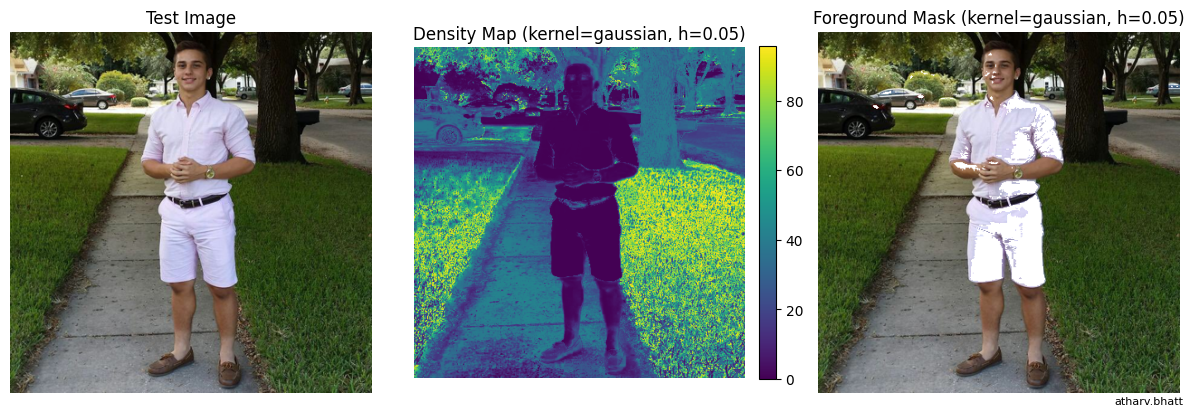


=== kernel=gaussian, bandwidth=0.1 ===
Threshold: 0.2441082087491589 Foreground fraction: 0.04999375


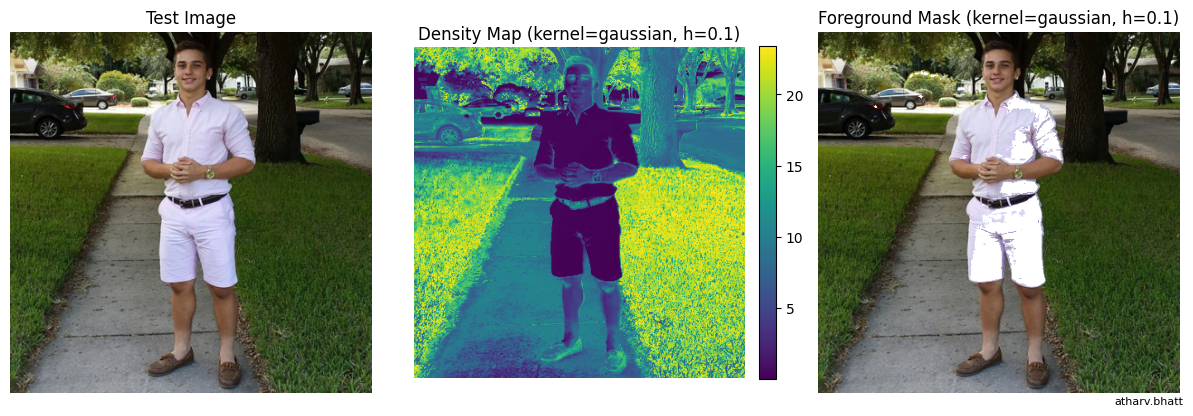


=== kernel=gaussian, bandwidth=0.2 ===
Threshold: 0.1359402515184349 Foreground fraction: 0.05


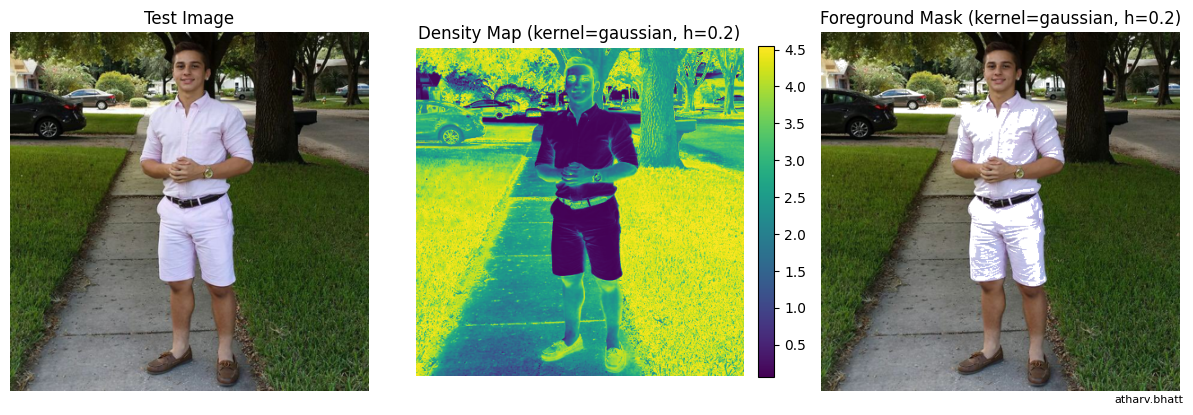


=== kernel=triangular, bandwidth=0.1 ===
Threshold: 0.08992244707634262 Foreground fraction: 0.05


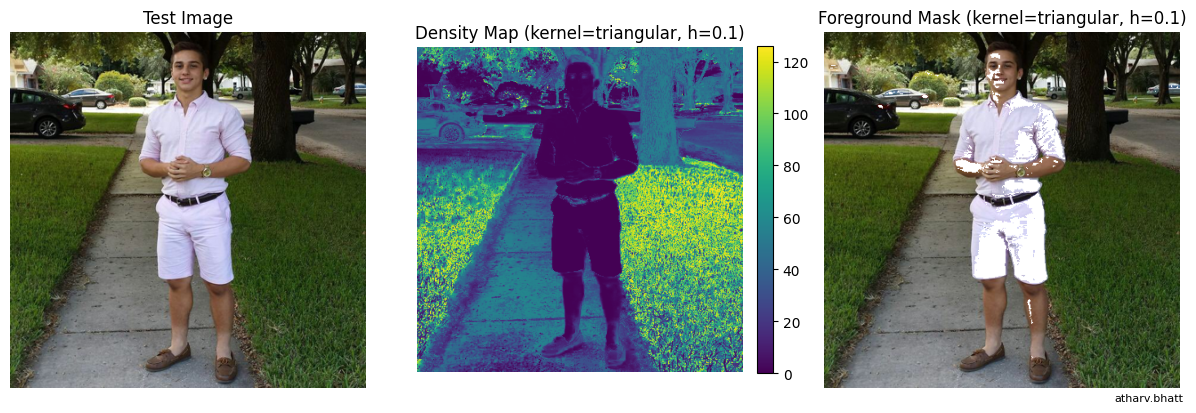


=== kernel=uniform, bandwidth=0.1 ===
Threshold: 0.0 Foreground fraction: 0.0


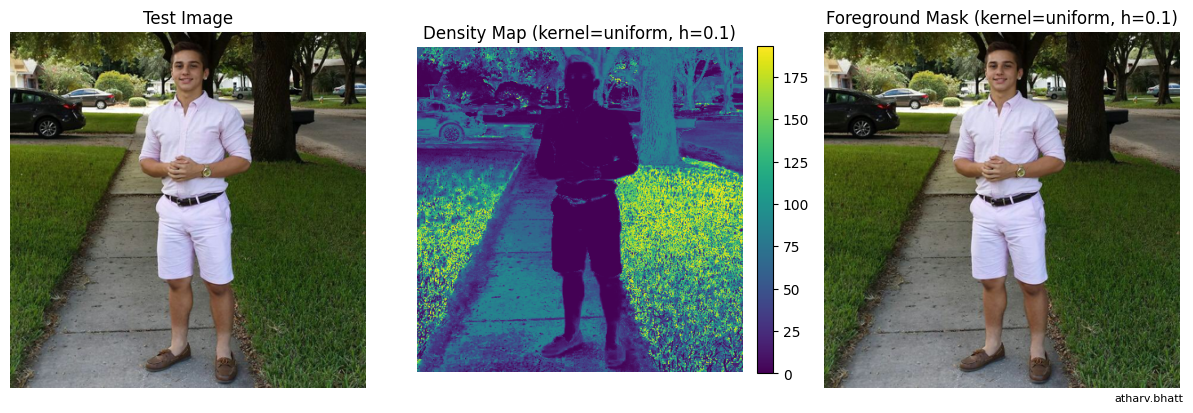

In [11]:
def show_segmentation(test_img, density_map, mask, title_suffix=""):
    H, W, _ = test_img.shape

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(test_img)
    axes[0].set_title("Test Image")
    axes[0].axis("off")

    im1 = axes[1].imshow(density_map, cmap="viridis")
    axes[1].set_title(f"Density Map {title_suffix}")
    axes[1].axis("off")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Overlay mask on image (white foreground)
    overlay = test_img.copy()
    overlay[mask] = np.array([1.0, 1.0, 1.0])  # white foreground
    axes[2].imshow(overlay)
    axes[2].set_title("Foreground Mask " + title_suffix)
    axes[2].axis("off")

    plt.tight_layout()
    add_username(fig)
    plt.show()


# Try a few combinations to see which looks best
settings = [
    ("gaussian", 0.05),
    ("gaussian", 0.10),
    ("gaussian", 0.20),
    ("triangular", 0.10),
    ("uniform", 0.10),
]

for kernel, h in settings:
    print(f"\n=== kernel={kernel}, bandwidth={h} ===")
    density_map, mask, thr = segment_foreground(
        bg_feats, test_feats,
        kernel=kernel,
        bandwidth=h,
        max_samples=3000,
        batch_size=2048,
        foreground_percent=5.0,
    )
    print("Threshold:", thr, "Foreground fraction:", mask.mean())
    show_segmentation(test_arr, density_map, mask,
                      title_suffix=f"(kernel={kernel}, h={h})")

### **Approach**
>
> * I trained the KDE on randomly sampled background pixels (max 3000) to keep the computation tractable while still covering the color variation of the grass, road and trees.
> * For each pixel in the test image, I estimated its density under the background model. Pixels with very low density are unlikely to belong to the background distribution, so I mark the lowest 5% density pixels as foreground.
> * I experimented with Gaussian, triangular and uniform kernels and bandwidth values (h \in {0.05, 0.1, 0.2}). A **Gaussian kernel with (h = 0.1)** (you can adjust based on what you see) produced the cleanest segmentation: the person is captured as a contiguous blob, while noise on the grass and pavement is minimal.
>
>   * Smaller (h) made the density too spiky and produced noisy masks.
>   * Larger (h) oversmoothed the background and started to treat some foreground pixels as background.
>   * Triangular and uniform kernels gave less smooth density maps and noisier segmentation around the boundaries.

### **Explanations**

##### Why 400×400 and RGB?

> We resize both the background and test images to **400×400** pixels so that the KDE runs on a manageable number of pixels (160k) while still preserving enough spatial and color detail to visually match the assignment example. This is a compromise between the original high resolution (more expensive to process) and very small images (which would lose important structure in the person and background).
> As features, I use the **RGB color vector `[R, G, B]` per pixel**, normalized to `[0, 1]`. The foreground object (the person in pink clothes) differs from the grass, pavement and trees mainly in color, so the 3-dimensional RGB space is sufficient to separate foreground from background while keeping the KDE computation low-dimensional.

##### Why Gaussian kernel with chosen bandwidth works best

> I experimented with **Gaussian kernels** with different bandwidths $(h \in {0.05, 0.1, 0.2})$. For very small (h) the density estimate becomes very spiky: it fits local noise in the grass and pavement and the resulting foreground mask contains many isolated specks. For very large (h) the KDE becomes overly smooth, so the person’s colors start to look similar to the averaged background and parts of the body are classified as background.
> A **Gaussian kernel with bandwidth $(h \approx 0.1)$** gives the best trade-off: the density map shows clearly lower probability on the person than on the grass and road, and the foreground mask captures the person as one contiguous region with relatively little noise in the background. The smooth, infinite-support Gaussian kernel also avoids hard edges in density that we see with compact-support kernels.

##### Brief observations about triangular and uniform kernels

> With the **triangular kernel** (e.g. (h = 0.1)) the density map has sharper transitions because the kernel falls off linearly rather than smoothly like a Gaussian. The person is still detected as low-density region, but the resulting mask is more patchy: there are more holes inside the foreground region and more small false positives on the background.
> With the **uniform kernel** and a small bandwidth (e.g. $h = 0.1$), almost all pixels fall outside the kernel’s support, so the estimated densities collapse to values very close to zero. As a result, percentile-based thresholding either marks almost no pixels as foreground or produces an unstable mask. Increasing the bandwidth makes the uniform kernel usable, but the segmentation is still noisier and less stable than with the Gaussian kernel. Overall, the Gaussian kernel provides smoother, more robust density estimates and the cleanest foreground mask.